# Simulation of likelhood fitting

In this notebook, I simulate spike counts data from a known distribution, and fit a DNN to recover the likelihood function. I then compare the recovered likelihood functions to the "ground-truth" likelhood functions computed from the known distribution.

In [1]:
import datajoint as dj
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

%matplotlib inline

from numpy.linalg import inv

from v1_likelihood import train
from v1_likelihood.train import CVTrainedModel, ModelDesign, BinConfig, CVSet, CVTrainedModel

dj.config['display.limit'] = 40

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Connecting eywalker@10.28.0.34:3306


In [2]:
def stat_logp(lp):
    nbins = lp.size(1)
    v = lp - lp.max(dim=1, keepdim=True)[0]
    post = torch.exp(v)
    ro_pos = Variable(torch.arange(nbins).type(post.data.type()))
    mu = (ro_pos*post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True)
    sigma = torch.sqrt(((ro_pos - mu).pow(2)*post).sum(dim=1) / post.sum(dim=1))
    mu = mu.view(mu.numel())
    return mu, sigma

## Simulate data

First, I simulate stimulus orientation drawn from the mixture of two Gaussian distributions. Both have $\mu=270^\circ$ but standard deviations differ $\sigma_A = 3^\circ$ and $\sigma_B = 15^\circ$.

In [189]:
sigmaA = 3
sigmaB = 15
stim_center = 0

In [190]:
n_trials = 1000
sv = np.random.choice([sigmaA, sigmaB], size=n_trials)
ori = np.random.randn(n_trials) * sv + stim_center

Now I simulate spike counts over an array consisting of 96 "multi-units". I assign a preferred orientation $\theta$ to each multi-unit. Each multi-unit has a Gaussian orietation tuning curve centered at it's preferred orientation. The standard deviation and the amplitude of the Gaussian tuning curves are identical for all multi-units in this simple simulation.

In [191]:
n_ch = 96
centers = np.linspace(-40, 40, n_ch)[:, None]
sigmas = 15
#amplitude = 10 
amps = [6]
amplitude = 6 * np.ones(n_trials) #np.random.choice(amps, size=n_trials)#np.random.rand(n_trials)*0 + 2
#amplitude = 4
#amplitude = np.random.choice([1], size=n_trials) * 5

# this is the expected value of the spike counts for each stimulus
mus = (amplitude * np.exp(-(ori - centers)**2/ 2/sigmas**2)).T

# we then draw spike count samples from the independent Poisson distribution
counts = np.random.poisson(mus)

Specify orientation binning parameters and center of bins

In [194]:
nbins = 91
delta = 1
pv = (np.arange(nbins) - nbins//2) * delta

Here I go ahead and compute the log-likelihood $\log p(\mathbf{r}|s)$ already. The prior is computed here as well.

## Fit tuning curves

In [196]:
ct = counts.T

mu_counts = (ct * ori).sum(axis=1, keepdims=True) / ct.sum(axis=1, keepdims=True)
sigma_counts = np.sqrt((ct * ori**2).sum(axis=1, keepdims=True) / ct.sum(axis=1, keepdims=True) - mu_counts**2)
max_counts = counts.max(axis=0)

from scipy.optimize import curve_fit


def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/2/(sigma**2))

curve_fit(gaus, ori, counts[:, 0], p0=[max_counts[0], mu_counts[0], sigma_counts[0]])

In [197]:
avg_amplitude = amplitude.mean()
Lsum = 0
for amp in amps:
    f = amp * np.exp(-(centers-pv)**2 / sigmas**2)[None, ...]
    logl_partial = (counts[..., None] * np.log(f)).sum(axis=1) - f.sum(axis=1)
    Lsum += np.exp(logl_partial)
logl = np.log(Lsum / len(amps))
#f = amplitude[:, None, None] * np.exp(-(centers-pv-270)**2 / sigmas**2)
#logl = (counts[..., None] * np.log(f)).sum(axis=1) - f.sum(axis=1)
prior = np.log(np.exp(- pv**2 / 2 / sigmaA**2) / sigmaA + np.exp(- pv**2 / 2 / sigmaB**2) / sigmaB)
#f = amplitude * np.exp(-(centers-pv-270)**2 / sigmas**2)
#logl = counts @ np.log(f) - f.sum(axis=0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [198]:
p = np.round((ori - stim_center)/ delta) + (nbins//2)
pos = (p >= 0) & (p < nbins)

# remove trials with orientation falling out of the binned orientation domain
p = p[pos]
counts = counts[pos]
logl = logl[pos]

# split into train, validation, and test set
fraction = 0.8
N = len(counts)
split = round(N * fraction)
pos = np.random.permutation(N)
train_pos = pos[:split]
valid_pos = pos[split:]

train_counts = counts[train_pos]
train_ori = p[train_pos]
train_logl = logl[train_pos]
train_logl = train_logl - train_logl.max(axis=1, keepdims=True)
train_amp = amplitude[train_pos]

valid_counts = counts[valid_pos]
valid_ori = p[valid_pos]

valid_logl = logl[valid_pos]
valid_logl = valid_logl - valid_logl.max(axis=1, keepdims=True)
valid_amp = amplitude[valid_pos]

Turn datasets into tensors and place them on GPU as needed.

In [199]:
train_x = torch.Tensor(train_counts)
train_t = torch.Tensor(train_ori).type(torch.LongTensor)

valid_x = Variable(torch.Tensor(valid_counts)).cuda()
valid_t = Variable(torch.Tensor(valid_ori).type(torch.LongTensor)).cuda()

prior = Variable(torch.Tensor(prior)).cuda()

train_dataset = TensorDataset(train_x, train_t)
valid_dataset = TensorDataset(valid_x, valid_t)

## Network definition and training

Define the simple multi-layer fully-connected neural network.

In [200]:
class Net(nn.Module):
    def __init__(self, n_channel=96, n_hidden=100, n_output=nbins, dropout=0.1, std=0.01):
        super().__init__()
        self.n_channel = n_channel
        self.std = std
        self.n_output = n_output
        self.dropout = dropout
        
        if not isinstance(n_hidden, (list, tuple)):
            n_hidden = (n_hidden,)
        
        self.n_hidden = n_hidden
        
        n_prev = n_channel
        
        hiddens = []
        
        for n in n_hidden:
            hiddens.append(nn.Linear(n_prev, n))
            hiddens.append(nn.ReLU())
            if dropout > 0.0:
                hiddens.append(nn.Dropout(p=dropout, inplace=True))
            n_prev = n
        if len(hiddens) > 0:
            self.hiddens = nn.Sequential(*hiddens)
        else:
            self.hiddens = None
        self.ro_layer = nn.Linear(n_prev, n_output)
        
        self.initialize()
        
        
    def forward(self, x):
        if self.hiddens is not None:
            x = self.hiddens(x)
        x = self.ro_layer(x)
        return x
    
    def initialize(self):
        def fn(mod):
            if isinstance(mod, nn.Linear):
                normal(mod.weight, std=self.std)
                constant(mod.bias, 0)
        self.apply(fn)

Also define the objective function used during early-stopping

In [201]:
def stat_logp(lp):
    nbins = lp.size(1)
    v = lp - lp.max(dim=1, keepdim=True)[0]
    post = torch.exp(v)
    ro_pos = Variable(torch.arange(nbins).type(post.data.type()))
    mu = (ro_pos*post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True)
    sigma = torch.sqrt(((ro_pos - mu).pow(2)*post).sum(dim=1) / post.sum(dim=1))
    mu = mu.view(mu.numel())
    return mu, sigma

In [202]:
def moments(lp, *vals):
    nbins = lp.size(1)
    v = lp - lp.max(dim=1, keepdim=True)[0]
    post = torch.exp(v)
    ro_pos = Variable(torch.arange(nbins).type(post.data.type()))
    ms = [(ro_pos**v * post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True) for v in vals]
    return ms

In [203]:
def objective(net, x=None, t=None):
    if x is None and t is None:
        x = valid_x
        t = valid_t
    net.eval()
    y = net(x)
    posterior = y + prior
    _, loc = torch.max(posterior, dim=1)
    #loc, _ = stat_logp(posterior)
    diff = t.double() - loc.double()
    v =diff.pow(2).mean().sqrt() * delta
    return v.data.cpu().numpy()[0]
    #return loss(valid_y, valid_t).data.cpu().numpy()[0]

## Try linear regression

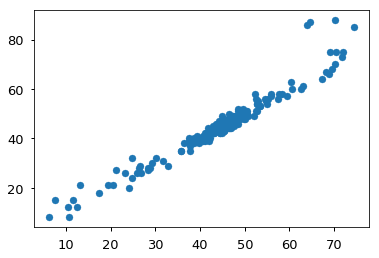

In [204]:
def extend_ones(x):
    return np.concatenate([x, np.ones([x.shape[0], 1])], axis=1)

tc = extend_ones(train_counts)

w = inv(tc.T @ tc + np.diag(np.ones(tc.shape[1]) * 0.0001)) @ tc.T @ train_ori

t_hat = extend_ones(valid_counts) @ w

plt.scatter(t_hat, valid_ori)

In [205]:
np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta

3.3363946831223212

## Fit NN

In [206]:
net = Net(n_channel=n_ch, n_output=nbins, n_hidden=[400, 400], std=0.0001, dropout=0.4)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()

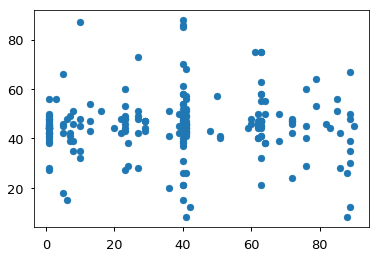

In [207]:
yv = net(valid_x).data.cpu().numpy()
loc = np.argmax(yv, axis=1)
plt.scatter(loc, valid_ori)

## Ground truth

On training set

0.66208553 1.7102356950624764


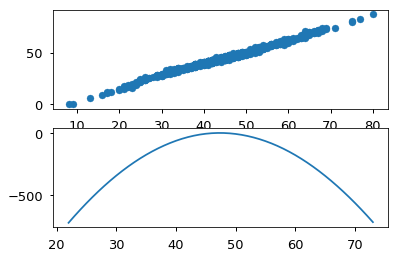

In [209]:
y = Variable(torch.Tensor(train_logl).cuda())
y = y + prior
gt_sigma =  (stat_logp(y)[1] * delta).data.cpu().numpy().mean()
#idx, _ = stat_logp(y)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, train_ori)


print(gt_sigma, np.sqrt(np.mean((t_hat.ravel() - train_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

On validation set

0.6780259 2.1908902300206643


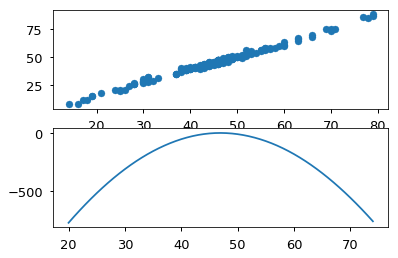

In [210]:
y = Variable(torch.Tensor(valid_logl).cuda())
y = y + prior
gt_sigma =  (stat_logp(y)[1] * delta).data.cpu().numpy().mean()
#idx, _ = stat_logp(y)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(gt_sigma, np.sqrt(np.mean((t_hat.ravel() - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

### Model prediction on the validation set

9.631199302267605


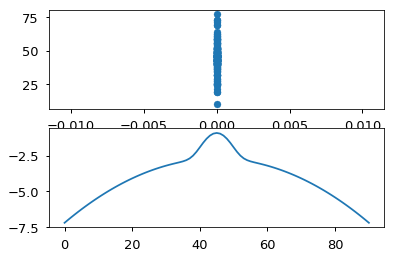

In [148]:
net.eval()
y = net(valid_x)


y = y + prior

#idx, _ = stat_logp(y)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

### Train the network

In [149]:
net.std = 1e-2 # 3e-2
net.initialize()

alpha = 30#20 #3e-2 #7e-3 #1e-3


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)
#0.03
learning_rates =  0.03 * 3.0**(-np.arange(3))

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch, valid_score in early_stopping(net, objective, interval=20, start=100, patience=20, max_iter=300000, maximize=False):
        data_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
        for x_, t_ in data_loader:
            x, t = Variable(x_).cuda(), Variable(t_).cuda()
            net.train()
            optimizer.zero_grad()
            y = net(x)
            post = y + prior
            val, _ = post.max(1, keepdim=True)
            post = post - val
            #sparcity = y.abs().sum(1).mean()
            conv_filter = Variable(torch.from_numpy(np.array([-0.25, 0.5, -0.25])[None, None, :]).type(y.data.type()))
            smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()
            score = loss(post, t)
            score = score + alpha * smoothness
            score.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('Score: {}'.format(score.data.cpu().numpy()[0]))
        #scheduler.step()
        
net.eval()





 LEARNING RATE: 0.03
Score: 3.3153269290924072
Score: 3.4753215312957764
[120|01/20] -/-> 9.631199302267605
Score: 3.498155117034912
Score: 3.5546226501464844
[140|01/20] ---> 8.687922651589389
Score: 2.9809741973876953
Score: 2.6403589248657227
[160|00/20] ---> 6.635887280537546
Score: 2.789560556411743
Score: 2.6164512634277344
[180|00/20] ---> 5.021951811795888
Score: 2.5290980339050293
Score: 2.7285046577453613
[200|00/20] ---> 3.26266762021509
Score: 2.111732006072998
Score: 2.377347946166992
[220|00/20] ---> 3.050409808533929
Score: 2.0874178409576416
Score: 2.2473301887512207
[240|00/20] ---> 2.8044607324760316
Score: 2.147202968597412
Score: 2.2005507946014404
[260|00/20] ---> 2.723967694375247
Score: 1.971616506576538
Score: 2.263108015060425
[280|00/20] ---> 2.4310491562286436
Score: 2.248670816421509
Score: 2.1024038791656494
[300|01/20] -/-> 2.6804850307360417
Score: 2.203251600265503
Score: 1.8767666816711426
[320|02/20] -/-> 2.5278449319529077
Score: 1.802324414253234

Net(
  (hiddens): Sequential(
    (0): Linear(in_features=96, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace)
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace)
  )
  (ro_layer): Linear(in_features=400, out_features=91, bias=True)
)

In [150]:
objective(net, Variable(train_x).cuda(), Variable(train_t).cuda())

1.6483769086714668

In [151]:
objective(net, valid_x, valid_t)

1.9339079605813716

In [152]:

y = net(valid_x)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = stat_logp(y)[0].data.cpu().numpy()
ds = (np.arange(nbins) - loc[:, None]) ** 2
avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta

In [153]:
avg_sigma

2.653571281767463

In [154]:
y.shape

torch.Size([200, 91])

In [155]:
mu, s = stat_logp(y)

In [156]:
s.data.cpu().numpy().mean()

2.6535711

BlendedAffine2D(
    IdentityTransform(),
    BboxTransformTo(
        TransformedBbox(
            Bbox(x0=0.125, y0=0.125, x1=0.35294117647058826, y1=0.34705882352941175),
            BboxTransformTo(
                TransformedBbox(
                    Bbox(x0=0.0, y0=0.0, x1=3.5, y1=5.0),
                    Affine2D(
                        [[100.   0.   0.]
                         [  0. 100.   0.]
                         [  0.   0.   1.]]))))))


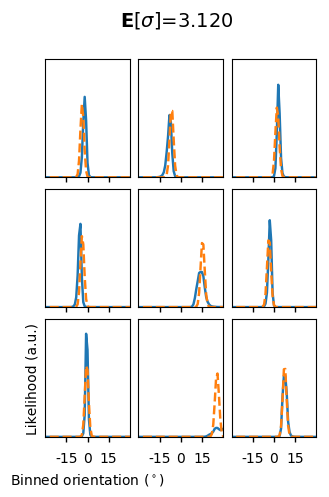

In [185]:
from itertools import count

#y = net(Variable(train_x).cuda())
y = net(valid_x)

#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)


#gt = np.exp(train_logl)
gt = np.exp(valid_logl)
gt = gt / gt.sum(axis=1, keepdims=True)


loc = yd.argmax(axis=1)
loc_gt = gt.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta


n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(3.5, 5), dpi=100)

p = np.random.permutation(len(yd))

for c, ((i, j), ax) in zip(p, np.ndenumerate(axs)):
    line, = ax.plot(pv, yd[c])
    ax.plot(pv, gt[c], '--')
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ylabel = ax.set_ylabel('Likelihood (a.u.)', fontsize=10)
        print(ylabel.get_transform())
        ax.set_xlabel('Binned orientation ($^\circ$)', fontsize=10)
        ax.set_xticks([-15, 0, 15])
        
    else:
        pass
        #ax.set_xticklabels([])
    ax.set_xticklabels([-15, 0, 15], fontsize=10)
    ax.set_xlim([-30, 30])
fig.subplots_adjust(wspace=0.1, hspace=0.1)


fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)
fig.savefig('')

In [173]:
eps = 1e-15
KL = ((np.log(gt + eps) - np.log(yd + eps)) * gt).sum(axis=1)

(array([91., 44., 20., 18., 12., 10.,  3.,  1.,  0.,  1.]),
 array([0.01590424, 0.29764764, 0.57939105, 0.86113446, 1.14287787,
        1.42462128, 1.70636469, 1.9881081 , 2.26985151, 2.55159492,
        2.83333833]),
 <a list of 10 Patch objects>)

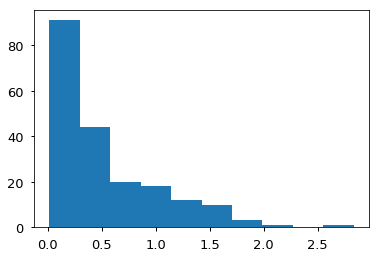

In [174]:
plt.hist(KL)

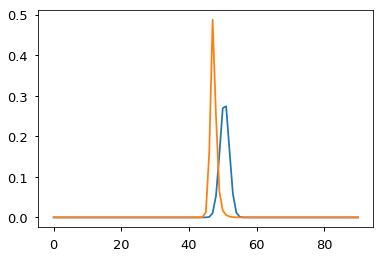

In [171]:
plt.plot(gt[169])
plt.plot(yd[169])

In [170]:
np.argmax(KL)

169

In [159]:
[mu_yd, sigma_yd] = stat_logp(Variable(torch.Tensor(np.log(yd))))
[mu_gt, sigma_gt] = stat_logp(Variable(torch.Tensor(np.log(gt))))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [160]:
sigma_gt = sigma_gt.data.cpu().numpy()
sigma_yd = sigma_
np.abs(sigma_gt.data.cpu().numpy() - sigma_yd.data.cpu().numpy())

NameError: name 'sigma_' is not defined

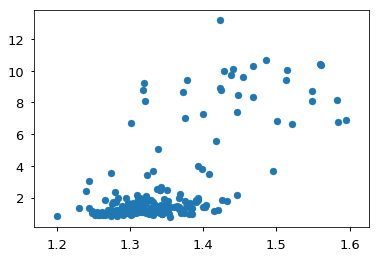

In [161]:
plt.scatter(sigma_gt, sigma_yd)

In [120]:
def moments(lp, *vals, delta=1):
    nbins = lp.size(1)
    #v = lp - lp.max(dim=1, keepdim=True)[0]
    post = lp #torch.exp(v)
    ro_pos = Variable(torch.arange(nbins).type(post.data.type()) - nbins//2) * delta
    mu = ((ro_pos * post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True))
    var = ((ro_pos - mu)**2 * post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True)
    ms = [(((ro_pos - mu)**order * post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True))**(1/order) for order in vals]
    return [mu, var] + ms

In [121]:
m_vals = [3, 4]
yd_moments = moments(Variable(torch.Tensor(yd)), *m_vals)
gt_moments = moments(Variable(torch.Tensor(gt)), *m_vals)

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


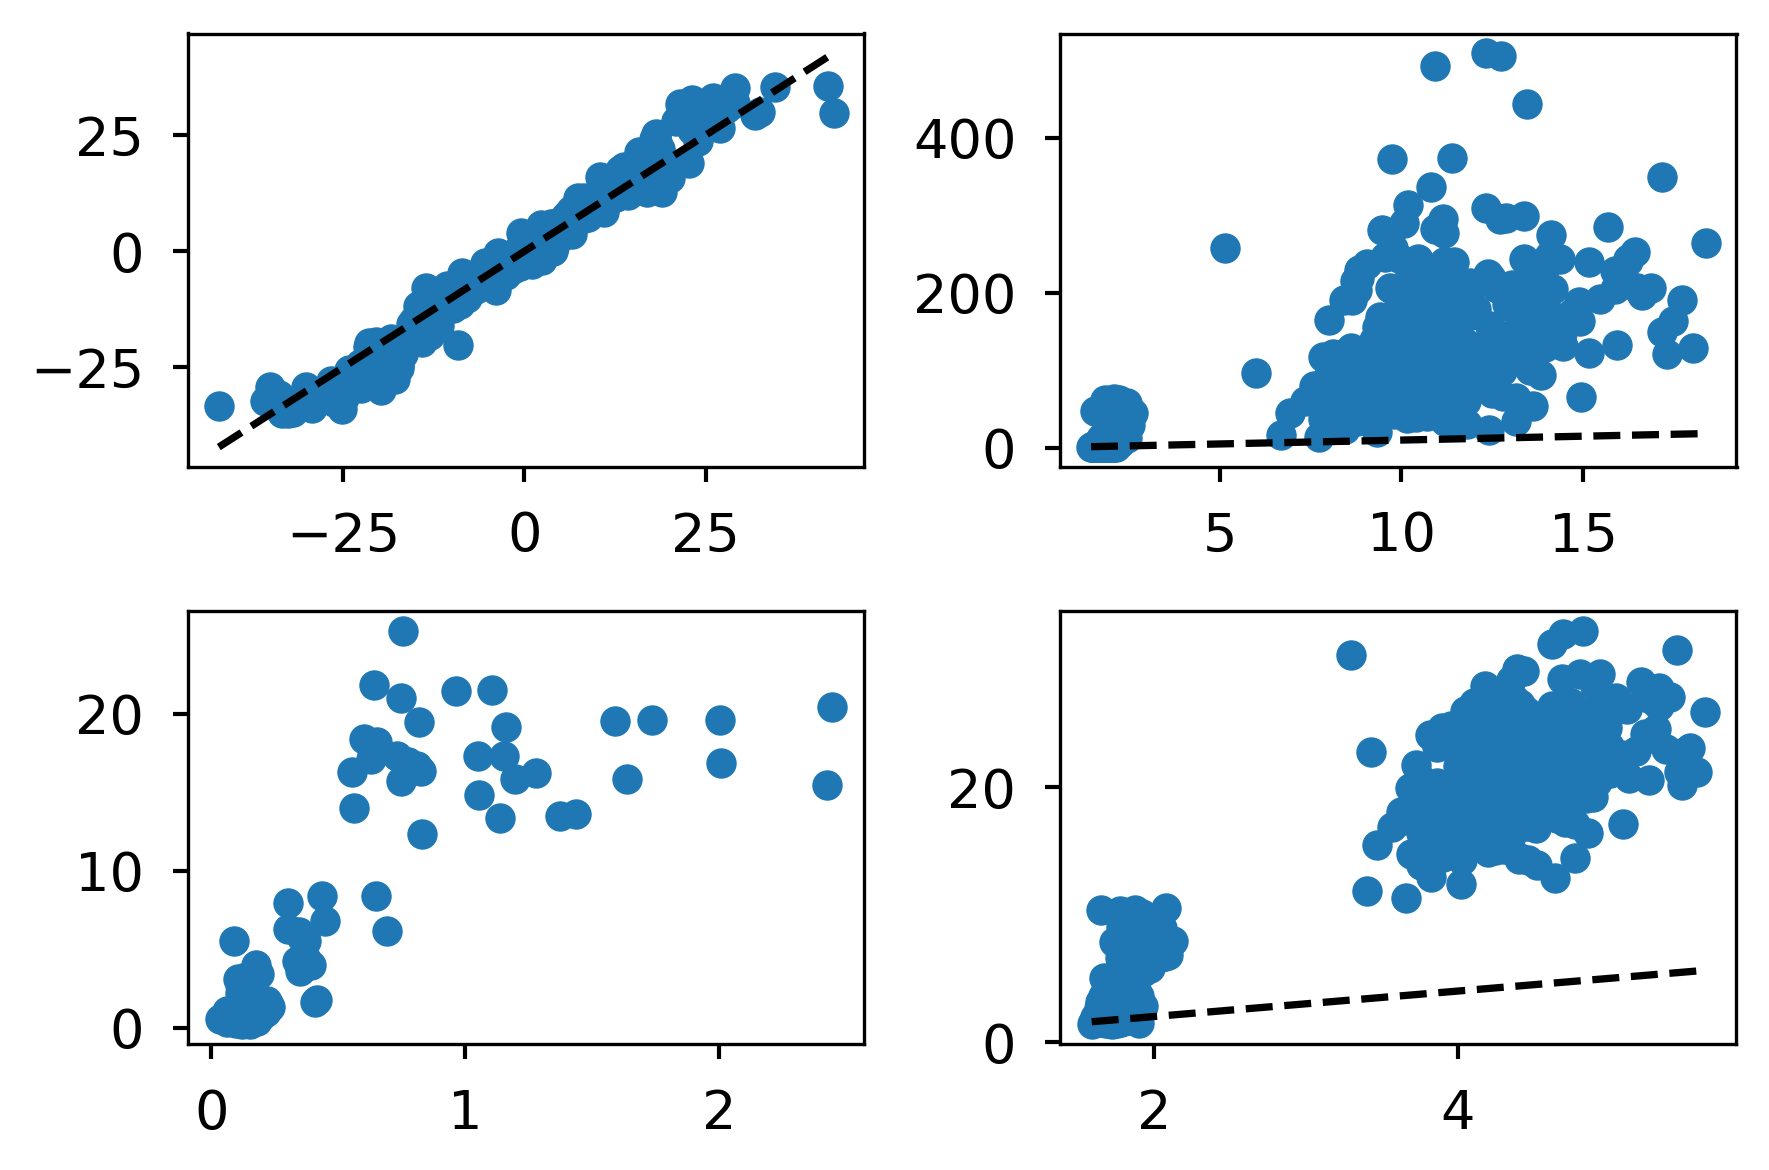

In [122]:
fig, axs = plt.subplots(2, 2, dpi=300)

for ydm, gtm, ax in zip(yd_moments, gt_moments, axs.ravel()):
    ax.scatter(gtm*delta, ydm*delta)
    minv = gtm.data.cpu().numpy().min()
    maxv = gtm.data.cpu().numpy().max()
    x = np.linspace(minv, maxv, 100)
    ax.plot(x, x, 'k--')
    
fig.tight_layout()

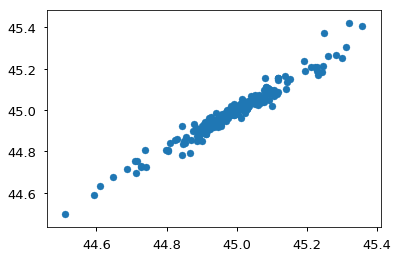

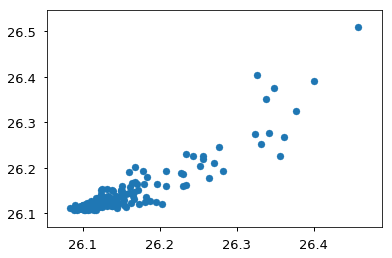

In [732]:
plt.scatter(mu_yd, mu_gt)
plt.figure()
plt.scatter(sigma_yd, sigma_gt)

4.510743783998325


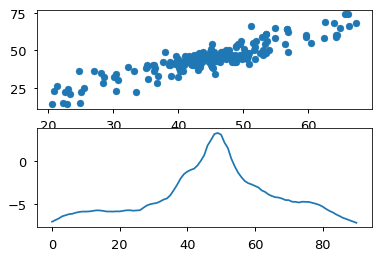

In [160]:
net.eval()
y = net(valid_x)


y = y + prior

idx, _ = stat_logp(y)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

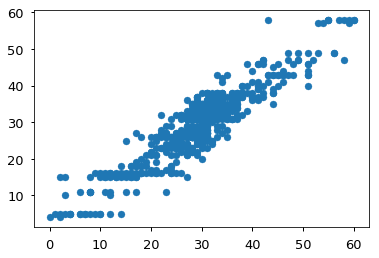

In [515]:
plt.scatter(valid_t, loc)

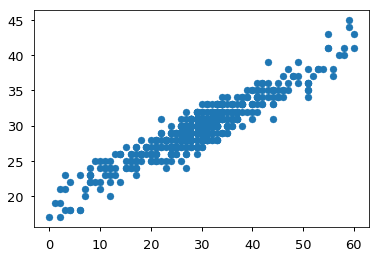

In [516]:
plt.scatter(valid_t, loc_gt)

## Measure std of likelihood functions

In [21]:
loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

np.mean(np.sqrt(np.sum(yd * ds, axis=1)))

8.930213504892635

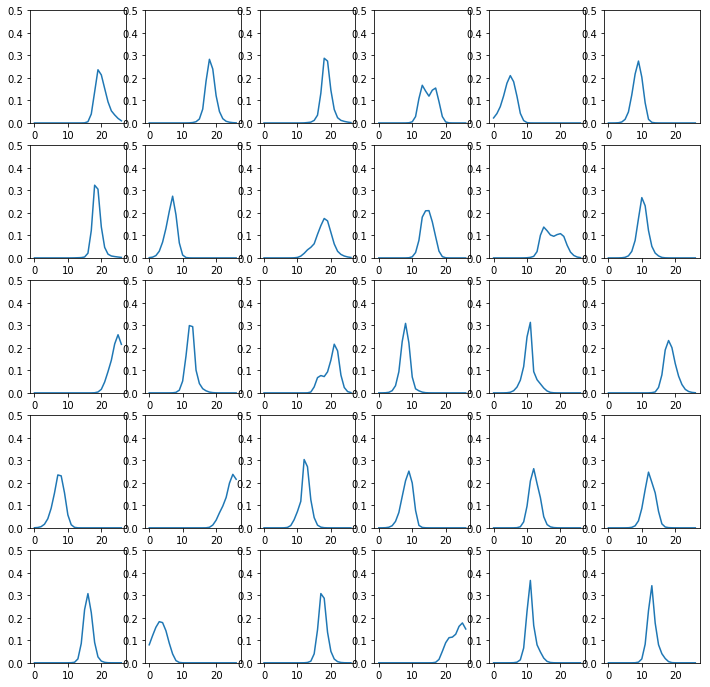

In [44]:
from itertools import count

y = net(valid_x)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

fig, axs = plt.subplots(5, 6, figsize=(12, 12))
for i, ax in zip(count(), axs.ravel()):
    ax.plot(yd[i])
    ax.set_ylim([0, 0.5])

In [ ]:
data = fetch(class_discrimination.ClassDiscriminationTrial * class_discrimination.SpikeCountTrials * class_discrimination.CSCLookup  & class_discrimination.CleanSpikeCountTrials & self, '*');
            data = dj.struct.sort(data, 'trial_num');
            contrast = fetchn(self, 'dataset_contrast');
            all_contrast = arrayfun(@num2str, [data.contrast], 'UniformOutput', false);
            pos = strcmp(all_contrast, contrast);
            dataSet = data(pos);
            if pack
                dataSet = packData(dataSet);
            end